In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.applications.vgg19 import preprocess_input
from keras.layers import Input, Conv2D, UpSampling2D, Layer, Conv2DTranspose
import os
import random
import math
import pickle
from skimage import img_as_float, exposure, data


IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import files
files.upload()


!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download ikarus777/best-artworks-of-all-time
!unzip -qq best-artworks-of-all-time.zip
!rm -rf images
!mv resized artwork
!rm best-artworks-of-all-time.zip artists.csv

!kaggle datasets download zaraks/pascal-voc-2007
!unzip -qq pascal-voc-2007
!rm pascal-voc-2007.zip
!rm -rf PASCAL_VOC
!rm -rf pascal_voc

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [02:07<00:00, 21.2MB/s]
100% 2.29G/2.29G [02:07<00:00, 19.3MB/s]
100% 1.65G/1.65G [01:35<00:00, 19.2MB/s]
100% 1.65G/1.65G [01:35<00:00, 18.7MB/s]


In [ ]:
def process_image(image):

    initial_width = tf.shape(image)[0]
    initial_width = tf.cast(tf.shape(image)[0], tf.float32)
    initial_height = tf.shape(image)[1]
    initial_height = tf.cast(tf.shape(image)[1], tf.float32)
    min_ = tf.minimum(initial_width, initial_height)
    min_ = tf.cast(min_, tf.float32)
    ratio = min_ / tf.constant(512, dtype=tf.float32)
    new_width = tf.cast(initial_width/ ratio, tf.int32)
    new_height = tf.cast(initial_height / ratio, tf.int32)
    image = tf.image.resize(image, [new_width, new_height])
    image = tf.image.random_crop(image, (256,256, 3))

    image = preprocess_input(image)

    return image


def process_image_simple(image):

    image = tf.image.resize(image, IMAGE_SIZE)
    image = preprocess_input(image)

    return image


def deprocess_img(processed_img):

    image = processed_img + np.array([103.939, 116.779, 123.68])
    image = tf.reverse(image, axis=[-1])
    image = tf.clip_by_value(image, 0.0, 255.0)

    return image


def load_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = process_image(image)

    return image


def load_image_for_test_ds(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = process_image_simple(image)

    return image

In [ ]:
style_images = os.listdir("/content/artwork/resized")
style_images = [os.path.join("/content/artwork/resized", path) for path in style_images]
train_style = style_images[: 4009]
val_style = style_images[4009: 5011]
test_style = style_images[5011 :]


content_images = os.listdir("/content/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages")
content_images = [os.path.join("/content/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages", path) for path in content_images]
random.shuffle(content_images)
train_content = content_images[: 4009]
val_content = content_images[4009 :]


content_images_test = os.listdir("/content/voctest_06-nov-2007/VOCdevkit/VOC2007/JPEGImages")
test_content = [os.path.join("/content/voctest_06-nov-2007/VOCdevkit/VOC2007/JPEGImages", path) for path in content_images_test]


train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(load_image, num_parallel_calls=AUTOTUNE)
)


val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(load_image, num_parallel_calls=AUTOTUNE)

)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(load_image_for_test_ds, num_parallel_calls=AUTOTUNE)

)


train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(load_image, num_parallel_calls=AUTOTUNE)

)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_content)
    .map(load_image, num_parallel_calls=AUTOTUNE)

)

test_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(load_image_for_test_ds, num_parallel_calls=AUTOTUNE)

)


train_ds = tf.data.Dataset.zip((train_style_ds, train_content_ds))
val_ds = tf.data.Dataset.zip((val_style_ds, val_content_ds))
test_ds = tf.data.Dataset.zip((test_style_ds, test_content_ds))


train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
def get_mean_std(x, epsilon=1e-5):

    axes = [1, 2]
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)

    return mean, standard_deviation


def ada_in(style, content):

    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean

    return t

In [ ]:
class NeuralStyleTransfer(tf.keras.Model):

    def __init__(self, encoder, decoder, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def calculate_loss(self, style, content):
        style_loss = 0.0
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)
        t = ada_in(style=style_encoded[-1], content=content_encoded[-1])
        reconstructed_image = self.decoder(t)
        reconstructed_features = self.encoder(reconstructed_image)
        content_loss = self.loss_fn(t, reconstructed_features[-1])

        for inp, out in zip(style_encoded, reconstructed_features):
              mean_inp, std_inp = get_mean_std(inp)
              mean_out, std_out = get_mean_std(out)
              style_loss += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
        style_loss = self.style_weight * style_loss
        total_loss = content_loss + style_loss
        return content_loss, style_loss, total_loss

    def train_step(self, inputs):
        style, content = inputs

        with tf.GradientTape() as tape:
            content_loss, style_loss, total_loss = self.calculate_loss(style,content)

        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.style_loss_tracker.update_state(style_loss)
        self.content_loss_tracker.update_state(content_loss)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs
        content_loss, style_loss, total_loss = self.calculate_loss(style,content)

        self.style_loss_tracker.update_state(style_loss)
        self.content_loss_tracker.update_state(content_loss)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


In [ ]:
val_style, val_content = next(iter(val_ds))

class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_style_encoded = self.model.encoder(val_style)
        val_style_encoded = val_style_encoded[-1]

        val_content_encoded = self.model.encoder(val_content)
        val_content_encoded = val_content_encoded[-1]

        val_t = ada_in(style=val_style_encoded, content=val_content_encoded)
        val_reconstructed_image = self.model.decoder(val_t)

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(val_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(val_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(val_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

In [ ]:
def get_encoder():

    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    encoder = keras.Model(vgg19.input, outputs)

    return encoder


In [ ]:
class SpatialReflectionPadding(Layer):

    def __init__(self, **kwargs):
        super(SpatialReflectionPadding, self).__init__(**kwargs)

    def call(self, xx):
        return tf.pad(xx, tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]]), mode="REFLECT")

def get_decoder():
        decoder_input = Input(shape=(32, 32, 512), name="input")
        x = SpatialReflectionPadding()(decoder_input)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
        x = UpSampling2D()(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
        x = UpSampling2D()(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
        x = UpSampling2D()(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
        x = SpatialReflectionPadding()(x)
        decoder_output = Conv2D(3, (3, 3), padding='valid', activation='linear')(x)
        decoder = keras.Model(decoder_input, decoder_output, name='decoder')

        return decoder

502/502 [==============================] - ETA: 0s - style_loss: 219246.9531 - content_loss: 350431.6875 - total_loss: 569678.4375

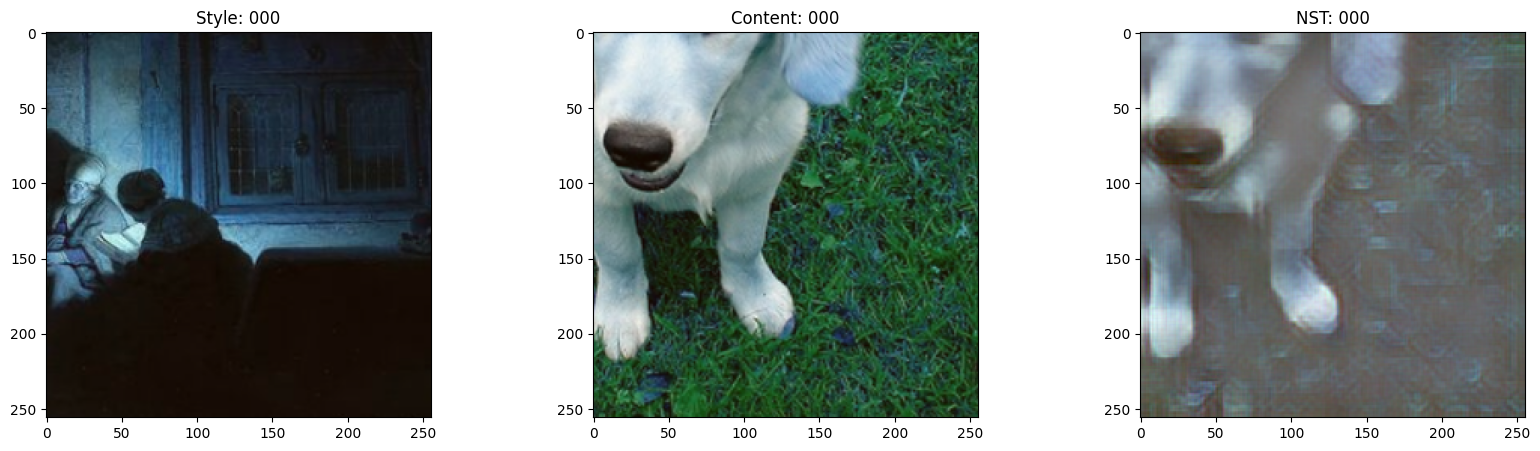

502/502 [==============================] - 244s 441ms/step - style_loss: 219246.9531 - content_loss: 350431.6875 - total_loss: 569678.4375 - val_style_loss: 125662.6328 - val_content_loss: 276283.2812 - val_total_loss: 401945.8750


In [ ]:

encoder = get_encoder()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, style_weight=2.0
)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4), loss_fn = keras.losses.MeanSquaredError()
)

history = model.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds,
    callbacks=[TrainMonitor()],
)

In [ ]:
!mkdir "decoder"
model.decoder.save_weights("decoder/weights")
!mkdir "history"
with open('history/history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

EVALUATION


In [ ]:
content_path = "sample_data/content1"
content = load_image_for_test_ds(content_path)
content = np.expand_dims(content, axis=0)

style_path = "sample_data/style1"
style = load_image_for_test_ds(style_path)
style = np.expand_dims(style, axis=0)

style_encoded = model.encoder(style)[-1]
content_encoded = model.encoder(content)[-1]

t = ada_in(style=style_encoded, content=content_encoded)
reconstructed_image = model.decoder(t)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,40))
ax_row = axes.flatten()
ax_content, ax_style, ax_reconstructed = ax_row

ax_content.imshow(tf.keras.utils.array_to_img(deprocess_img(content[0])))
ax_content.axis("off")

ax_style.imshow(tf.keras.utils.array_to_img(deprocess_img(style[0])))
ax_style.axis("off")

ax_reconstructed.imshow(tf.keras.utils.array_to_img(deprocess_img(reconstructed_image[0])))
ax_reconstructed.axis("off")

plt.show()

RUNTIME CONTROLS

In [ ]:
def content_style_trade_off(style_weight, style_encoded, content_encoded):

    return (1-style_weight)*content_encoded + style_weight*ada_in(style_encoded, content_encoded)


def style_interpolation(content_encoded, *style_weight_pairs):

    t = np.zeros(shape = content_encoded.shape)
    for pair in style_weight_pairs:
        style_encoded, weight = pair
        t += weight * ada_in(style_encoded, content_encoded)

    return t

def color_control(content_path, style_path):

    content = load_image_for_test_ds(content_path)
    style = load_image_for_test_ds(style_path)

    style_np = style.numpy()
    content_np = content.numpy()

    style_float = img_as_float(style_np)
    content_float = img_as_float(content_np)

    matched = exposure.match_histograms(style_float, content_float, multichannel=True)

    content = np.expand_dims(content, axis=0)
    matched = np.expand_dims(matched, axis=0)

    return content, matched


def load_image_with_binary_mask(image_path, limit):

    image = load_image_for_test_ds(image_path)
    gray_image = tf.image.rgb_to_grayscale(image)
    binary_mask = tf.where(gray_image > limit, 255, 0)
    mask = tf.image.resize(binary_mask, (32, 32))

    image = np.expand_dims(image, axis=0)
    mask = np.expand_dims(mask, axis=0)

    return image, mask


def get_t_with_binary_mask(mask, content, style1, style2):

    style_encoded1 = model.encoder(style1)[-1]
    style_encoded2 = model.encoder(style2)[-1]
    content_encoded = model.encoder(content)[-1]

    t1 = ada_in(style=style_encoded1, content=content_encoded)
    t2 = ada_in(style=style_encoded2, content=content_encoded)

    return tf.where(mask, t1, t2)
